In [1]:
#nbi:hide_in
#%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed,interact_manual,VBox,HBox
import ipywidgets as widgets
from scipy.optimize import fsolve
import nbinteract as nbi


In [2]:
#nbi:hide_in
def J1(a,b,c1,c2,d,h1,h2):
    return a-b*(h1+h2)-b*h1-c1-d*h1

def J2(a,b,c1,c2,d,h1,h2):
    return a-b*(h1+h2)-b*h2-c2-d*h2

def unconstrainedCournot(a,b,c1,c2,d):
    Q=(2*a-c1-c2)/(2*b+b+d)
    q1=(a-b*Q-c1)/(b+d)
    q2=(a-b*Q-c2)/(b+d)
    return [q1,q2]
def BR1(a,b,c1,d,h2):
    return max(0,(a-b*h2-c1)/(2*b+d))
def BR2(a,b,c2,d,h1):
    return max(0,(a-b*h1-c2)/(2*b+d))

def harvestFunction(a,b,c1,c2,d,e1,e2):
    if e1+e2 > sum(unconstrainedCournot(a,b,c1,c2,d)):
        if e1< unconstrainedCournot(a,b,c1,c2,d)[0]:
            return [e1,BR2(a,b,c2,d,e1)]
        elif e2 <unconstrainedCournot(a,b,c1,c2,d)[1]:
            return [BR1(a,b,c1,d,e2),e2]
        else:
            return unconstrainedCournot(a,b,c1,c2,d)
    else:
        if J1(a,b,c1,c2,d,e1,e2)>0 and J2(a,b,c1,c2,d,e1,e2)<0:
            return [e1,BR2(a,b,c2,d,e1)]
        elif J1(a,b,c1,c2,d,e1,e2)<0 and J2(a,b,c1,c2,d,e1,e2)>0:
            return [BR1(a,b,c1,d,e2),e2]
        else:
            return [e1,e2]


def costFcn(c1,c2,d,h1,h2):
    return c1*h1+0.5*d*h1**2 + c2*h2+0.5*d*h2**2

def revenueFcn(a,b,h1,h2):
    return (a-b*(h1+h2))*(h1+h2)

def totalProfit(a,b,c1,c2,d,h1,h2):
    prfit= revenueFcn(a,b,h1,h2) - costFcn(c1,c2,d,h1,h2)
    return prfit

def welfare(a,b,c1,c2,d,h1,h2):
    return (a+a-b*(h1+h2))*(h1+h2)/2-c1*h1-0.5*d*h1**2 - c2*h2-0.5*d*h2**2

def indexSet(l):
    mx=max(l)
    idx=[]
    for i in range(len(l)):
        if l[i]==mx:
            idx.append(i)
    return idx

#for a given share cap s and Qbar, return E*
def optE(a,b,c1,c2,d,Qbar,s):
    e1list=np.linspace(Qbar*s,Qbar*(1-s), int((2*s-1)*1000)+1)
    e2list=np.linspace(Qbar*(1-s),Qbar*s, int((2*s-1)*1000)+1)
    profitlist=[]
    optEset=[]
    for i in range(len(e1list)):
        h1,h2=harvestFunction(a,b,c1,c2,d,e1list[i],e2list[i])
        profitlist.append(totalProfit(a,b,c1,c2,d,h1,h2))
    for x in indexSet(profitlist): 
        optEset.append((e1list[x],e2list[x]))
    return optEset

def cost1(h1,c1,d):
     return c1*h1+0.5*d*h1**2
def cost2(h2,c2,d):
     return c2*h2+0.5*d*h2**2

def mc1(h1,c1,d):
    return c1+d*h1
def mc2(h2,c2,d):
    return c2+d*h2

def mincost(Q,c1,c2,d):
    if d>0:
        if Q<(c2-c1)/d:
            return cost1(Q,c1,d)
        else:
            q1=Q/2-(c1-(c1+c2)/2)/d
            q2=Q/2-(c2-(c1+c2)/2)/d
            return cost1(q1,c1,d)+cost2(q2,c2,d)
    elif d==0:
        return cost1(Q,c1,d)

def efficiencyIndex(c1,c2,d,h1,h2):
    return mincost(h1+h2,c1,c2,d)/costFcn(c1,c2,d,h1,h2)

def profit1(a,b,c1,c2,d,h1,h2):
    return (a-b*(h1+h2))*h1 -cost1(h1,c1,d)

def profit2(a,b,c1,c2,d,h1,h2):
    return (a-b*(h1+h2))*h2 -cost2(h2,c2,d)

def zeroProfitQ(a,b,c1,c2,d):
    Qhat=(2*a-c1-c2)/(2*b+d)    
    return Qhat
# 1st best welfare
def maxWelfare(a,b,c1,c2,d,q1,q2):
    Q=min(q1+q2, zeroProfitQ(a,b,c1,c2,d))
    return (a+a-b*Q)*Q/2-  mincost(Q,c1,c2,d)

def realizedWelfareRatio(a,b,c1,c2,d,h1,h2,q1,q2):
    return  welfare(a,b,c1,c2,d,h1,h2)/maxWelfare(a,b,c1,c2,d,q1,q2)

In [3]:
#nbi:hide_in

def plotAllFour(a,b,c1,c2,d,Qbar):
    plt.close()
    fig,ax = plt.subplots(1,4, figsize=(18, 4))
    e1list=np.linspace(0,Qbar,201)
    e2list=Qbar-e1list
    h1list=[]
    h2list=[]
    Hlist=[]
    profit1list=[]
    profit2list=[]
    profitList=[]
    mc1list=[]
    mc2list=[]
    for e1 in e1list:
        e2=Qbar-e1
        h1,h2 = harvestFunction(a,b,c1,c2,d,e1,Qbar-e1)
        h1list.append(h1)
        h2list.append(h2)
        Hlist.append(h1+h2)
        profit1list.append(profit1(a,b,c1,c2,d,h1,h2))
        profit2list.append(profit2(a,b,c1,c2,d,h1,h2))
        profitList.append(totalProfit(a,b,c1,c2,d,h1,h2))
        mc1list.append(mc1(h1,c1,d))
        mc2list.append(mc2(h2,c2,d))
    def plotProfit(ax,ee1):
        ax.set(xlim=[0,Qbar],ylim=[min(profit2list)*0.9,max(profitList)*1.05] ,xlabel=r"$q_1$",ylabel=r"Profit")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_linewidth(2.5)
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_linewidth(2.5)    
        h1,h2 = harvestFunction(a,b,c1,c2,d,ee1,Qbar-ee1)
        Pi=totalProfit(a,b,c1,c2,d,h1,h2)     
        Pi1=profit1(a,b,c1,c2,d,h1,h2) 
        Pi2=profit2(a,b,c1,c2,d,h1,h2) 
        ax.plot(e1list,profitList,label=r"Industry Profit : $\Pi$",lw=2 ,color="black",alpha=0.8)
        ax.plot(e1list,profit1list,label=r"$\pi_1$" ,color="red" ,alpha=0.8)
        ax.plot(e1list,profit2list,label=r"$\pi_2$" ,color="blue" ,alpha=0.8)
        ax.scatter(ee1,Pi,c="black",s=15,alpha=1,marker='o')
        ax.scatter(ee1,Pi1,c="black",s=22,alpha=1,marker='o')
        ax.scatter(ee1,Pi2,c="black",s=22,alpha=1,marker='o')
        ax.legend()
    def plotHarvest(ax,ee1):
        ax.set(xlim=[0,Qbar],ylim=[min(h2list)*0.9,max(Hlist)*1.05] ,xlabel=r"$q_1$",ylabel=r"Harvest")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_linewidth(2.5)
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_linewidth(2.5)    
        h1,h2 = harvestFunction(a,b,c1,c2,d,ee1,Qbar-ee1)
        ax.plot(e1list,Hlist,label=r"Industry Harvest : $H$",lw=2 ,color="black",alpha=0.8)
        ax.plot(e1list,h1list,label=r"$h_1$" ,color="red" ,alpha=0.8)
        ax.plot(e1list,h2list,label=r"$h_2$" ,color="blue" ,alpha=0.8)
        ax.scatter(ee1,h1+h2,c="black",s=15,alpha=1,marker='o')
        ax.scatter(ee1,h1,c="black",s=22,alpha=1,marker='o')
        ax.scatter(ee1,h2,c="black",s=22,alpha=1,marker='o')
        ax.legend()
    def plotMC(ax,ee1):
        ax.set(xlim=[0,Qbar],ylim=[min(mc1list)*0.9,max(mc2list)*1.05] ,xlabel=r"$q_1$",ylabel="Marginal Cost")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_linewidth(2.5)
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_linewidth(2.5)    
        h1,h2 = harvestFunction(a,b,c1,c2,d,ee1,Qbar-ee1)
        ax.plot(e1list,mc1list,label=r"$MC_1$" ,color="red" ,alpha=0.8)
        ax.plot(e1list,mc2list,label=r"$MC_2$" ,color="blue" ,alpha=0.8)
        ax.scatter(ee1,mc1(h1,c1,d),c="black",s=22,alpha=1,marker='o')
        ax.scatter(ee1,mc2(h2,c2,d),c="black",s=22,alpha=1,marker='o')
        ax.legend()
    
    def plotPhi(ax1):
        ax1.set(xlim=[0.5,1],xlabel=r"$s$",ylabel="Efficiency")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.yaxis.set_ticks_position('none') 
        ax1.xaxis.set_ticks_position('none') 
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])

        slist=np.linspace(0.5,1,51)
        realizedRatioLst=[]
        for s in slist:
            e1star,e2star = optE(a,b,c1,c2,d,Qbar,s)[0]  
            h1star,h2star = harvestFunction(a,b,c1,c2,d,e1star,e2star)  
            costEffIdx=round(efficiencyIndex(c1,c2,d,h1star,h2star),4)
            realizedRatio = round(realizedWelfareRatio(a,b,c1,c2,d,h1star,h2star,e1star,e2star),4)
            realizedRatioLst.append(realizedRatio)
        ax1.plot(slist,realizedRatioLst,label=r"$\Phi^W(s)$",marker='x',color="black",linestyle="dotted")
        ax1.legend()
        strrr=r"$\alpha=$" + str(a)+ "\n"+r"$\beta=$" + str(round(b,2))+ "\n"+r"$\theta_1=$"+ str(c1)+ "\n"+r"$\theta_2=$"+ str(round(c2,2))+ "\n"+ r"$\eta=$"+ str(round(d,2))+ "\n"+ r"$\bar{Q}=$"+ str(round(Qbar,2))
        # Label the parameter 
        ax1.annotate(strrr,(0.95,0.9))
        return ax1
    

    plotPhi(ax[3])
    def animate(i):
        ax[0].clear()
        ax[1].clear()
        ax[2].clear()
        #ax[3].clear()
        plotProfit(ax[0],e1list[i])
        plotHarvest(ax[1],e1list[i])
        plotMC(ax[2],e1list[i])
    
    anim = FuncAnimation(fig, animate,frames=len(e1list), interval=50)
    return anim

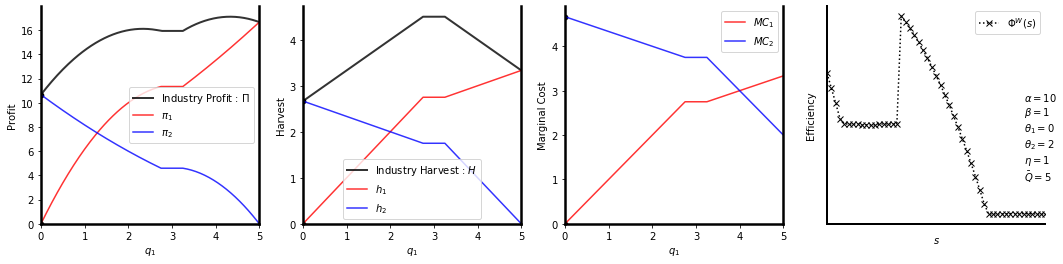

In [4]:
#nbi:hide_in

plotAllFour(a=10,b=1,c1=0,c2=2,d=1,Qbar=5)

In [5]:
#nbi:hide_in 
bb=widgets.BoundedFloatText(min=0,max=10,value=1,description=r"$\beta$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
cc1=widgets.BoundedFloatText(min=0,max=8,value=2,description=r"$\theta_1$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
cc2=widgets.BoundedFloatText(min=0,max=8,value=2,description=r"$\theta_2$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
dd=widgets.BoundedFloatText(min=0,max=10,value=1,description=r"$\eta$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
QQ=widgets.BoundedFloatText(min=1,max=10,value=5,description=r"$\bar{Q}$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
aa=widgets.BoundedFloatText(min=10,max=20,value=15,description=r"$\alpha$",step=0.1,layout=widgets.Layout(width='15%', height='100%'))
widgets.interactive(plotAllFour,{'manual': True},a= fixed(10),b=bb,c1=fixed(0),c2=cc2,d=dd,Qbar=QQ) #{'a':aa,'b':bb,'c1':cc1,'c2':cc2,'d':dd,'Qbar':QQ}


interactive(children=(BoundedFloatText(value=1.0, description='$\\beta$', layout=Layout(height='100%', width='…

In [6]:
#nbi:hide_in
nbi.publish("XinyuGuo17/test1/master", "HTML 4 graphs to show PhiW.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'HTML 4 graphs to show PhiW.ipynb'.
Converting notebook...



Successfully converted!

<a href="HTML 4 graphs to show PhiW.html" target="_blank" download>Click to download your webpage.</a>

To host your webpage, see the documentation:
<a href="https://www.nbinteract.com/tutorial/tutorial_publishing.html"
        target="_blank">
    https://www.nbinteract.com/tutorial/tutorial_publishing.html
</a>
